# Hunter S. Thompson Bot
Since I saw the Harry Potter chapter generated by Botnik Studio, I wanted to see it for Hunter S. Thompson. A few came out, but none from the doctor, so I decided to do it myself. Here I document that project. So far I've collected a bunch of Hunter S. Thompson's books and essays. I just downloaded all the text I could find, often with the incorrect name. I did not clean the text at all, and here are more or less the works I included:

In [61]:
#BOILERPLATE _______________________
#MODULES ______________________

import os
import re
import sys
import pickle
import numpy as np
import pandas as pd
import itertools
import operator
import pysftp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

from RNNmodule.SequenceClass import Sequences

idx = pd.IndexSlice
ROOT = os.environ['HOME'] + '/python/'

print 'modules loaded...'

modules loaded...


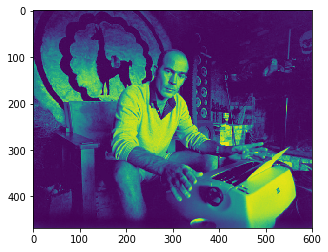

********************************************************************************
Works Included
********************************************************************************
Campaign Trail
Richard Nixon
the great shark hunt
Hells Angels
Fear and Loathing
The Motorcycle Gangs
input
letter1
Freak Power Rockies
Hollywood
Hippies
Song Sausage Creature
nine eleven
Kentucky Derby


In [65]:
img = mpimg.imread('/Users/pablomartin/python/Hunter/Extras/hunter.jpg')
plt.imshow(img)
plt.show()
print '*' * 80
print 'Works Included'
print '*' * 80
for text in os.listdir('/Users/pablomartin/python/Hunter/Input/'):
    tmp = text.replace('_', ' ')
    tmp = tmp[:tmp.find('.')]
    print tmp

## Favorite Phrases !
Over the entire process, I would save some of my favorite phrases that were too good too loose. Below is a list of what I thought were the funniest ones:

it was a deal with the seal.  
what would dare in the campaign beach.  
the sense of the sane thing.  
the scum of the strange  
the show of traffic lust  
and then he said they would not be the kind of goddamn true style.  
but now i was a beautiful slice  
the voters who try to accept the progressive story for the people  
he would have to be a half-hipzing 100 million technical thing  
we were after a black balloon screen on the street  
later that night i heard the press and the people who could handle the press conference.  
one of the most active cases of the "good shock"  
the mayor and the student rogf had the main toad gang  
this is apparent that its about this time she tells the press box in the beach.  
the only person who had been there to be a quick $200-a-year policeman  
the precision-jackhammer justice & november 15, 1961  
the chrcsm's reputation as "the cops" was a very expensive statement of a fig  
they were all known for a friendly kind of consistency.  
"you'll know your beer in your mouth," he said.  
"jesus!" he squnned his back on my back. "you're going to plunge?"   
"why? where's the goddamn bull?"  
when i finally got the beer and watched him as a man who was still struggling with a big smile  

## Preprocessing
First, we concatenate all the works together into one giant file. I'm removing non-ascii characters and making all letters lower case. Then I just chop up all the text into 100 character chunks as my x sample, and the next letter as the corresponding y label. I reshape the data and save it to disk. We went from 2.5MB to ~9GB, yikes.

In [3]:
run_again = 0
if run_again == 1:
    #read file
    raw_text = open(ROOT + 'Hunter/input.txt', 'r').read()
    #everything to lower case
    raw_text = raw_text.lower()
    #remove non-ascii characters
    raw_text = re.sub(r'[^\x00-\x7f]',r'', raw_text)

    # create mapping of unique chars to integers, and a reverse mapping
    chars = sorted(list(set(raw_text)))
    char_to_int = dict((c, i) for i, c in enumerate(chars))
    int_to_char = dict((i, c) for i, c in enumerate(chars))
    # summarize the loaded data
    n_chars = len(raw_text)
    n_vocab = len(chars)
    print "Total Characters: ", n_chars
    print "Total Vocab: ", n_vocab
    # prepare the dataset of input to output pairs encoded as integers
    seq_length = 100
    dataX = []
    dataY = []
    for i in range(0, n_chars - seq_length, 1):
        seq_in = raw_text[i:i + seq_length]
        seq_out = raw_text[i + seq_length]
        dataX.append([char_to_int[char] for char in seq_in])
        dataY.append(char_to_int[seq_out])
    n_patterns = len(dataX)
    print "Total Patterns: ", n_patterns
    # reshape X to be [samples, time steps, features]
    X = np.reshape(dataX, (n_patterns, seq_length, 1))
    # normalize
    X = X / float(n_vocab)
    # one hot encode the output variable
    y = np_utils.to_categorical(dataY)
    print 'saving data...'
    #saving data bulk - this file is ~9GB
    pickle.dump([X,y], open(ROOT + 'Hunter/input_XY.p','wb'))
    #sampling 100 random entries for seeds 
    sub_dataX = [dataX[w] for w in np.random.randint(0,len(dataX),100)]
    pickle.dump(sub_dataX, open(ROOT + 'Hunter/input_as_array.p' , 'wb'))
    pickle.dump(int_to_char, open(ROOT + 'Hunter/int_to_char.p', 'wb'))
    print 'saved data...'



Total Characters:  2552248
Total Vocab:  58
Total Patterns:  2552148
saving data...
saved data...


## Training Model
Once the data was prepared, running the model is "simple" enough. We are going to use an LSTM network with 2 layers, and 256 units in each layer. We will introduce dropout of 20% after each layer, and a last layer of size of our vocabulary with a softmax activation (standard). We are using a fairly 'large' mini-batch size of 512 so that it trains faster and for the gradients to be smoother. We include some checkpoints so we save the model every time there's been an improvement. Tensorflow by default selects a GPU if it's been configured properly so it's very straightforward to train. What was difficult was setting up the GPU, which was 2 days of Linux hell. We are using an Nvidia Tesla K40c GPU. The training code looked something like this:

In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

filepath= ROOT + 'Hunter/models256/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
# fit the model
model.fit(X, y, epochs=100, batch_size=512, callbacks=callbacks_list)

### Downloading Files
We are using the awesome pysftp library to check what the best model on epsilon is and download it. Then we run it to get the output 

In [3]:
#download a better model if it exists
def download_best_model(model_dir = 'Hunter/models512/', min_max = 'max'):
    with pysftp.Connection(host = "10.81.104.156", username = "pablo", password = "pablo2014") as srv:
        models_available = srv.listdir('/home/pablo/python/' + model_dir)
        model_loss = [float(str((w[w.find('.')-1:-5]))) for w in models_available]
        if min_max == 'max':
            best_model = models_available[np.argmax(model_loss)]
        elif min_max == 'min':
            best_model = models_available[np.argmin(model_loss)]
        if not os.path.isfile(ROOT  + model_dir + best_model):
            print 'downloading %s ...' %best_model
            srv.get('/home/pablo/python/' + model_dir + best_model,
                    '/Users/pablomartin/python/' + model_dir + best_model)
        else:
            print 'best model already downloaded...'
        print 'best model: %s' %best_model
    return best_model

def generate_text(model, output_length = 100, temp = 0.4):

    #figure out vocabulary dimensions from model
    n_vocab = model.output.shape[1].value

    #load number to character mapping
    int_to_char = pickle.load(open(ROOT + 'Hunter/Extras/int_to_char.p', 'rb'))

    # pick a random seed
    seeds = pickle.load(open(ROOT + 'Hunter/Extras/seeds.p', 'rb'))
    start = np.random.randint(0, len(seeds)-1)
    pattern = seeds[start]


    print '\n' + '*' * 80
    print 'GENERATED OUTPUT'
    print '*' * 80 + '\n'
    # generate characters
    for i in range(output_length):
        x = np.reshape(pattern, (1, len(pattern), 1))
        x = x / float(n_vocab)
        prediction = model.predict(x, verbose=0)

        by_max = np.argmax(prediction)
        by_probability = int(np.digitize(np.random.random(), np.cumsum(prediction)))
        options = [by_max, by_probability]
        index = options[np.random.random() > temp]

        result = int_to_char[index]
        seq_in = [int_to_char[value] for value in pattern]
        sys.stdout.write(result)
        pattern.append(index)
        pattern = pattern[1:len(pattern)]
    print "\n\n" + '*' * 80
    return


In [27]:
model_config = pickle.load(open(ROOT + 'Hunter/Extras/network_config256.p', 'rb'))
model = Sequential.from_config(model_config)
model.load_weights('/Users/pablomartin/python/Hunter/models256/weights-improvement-84-1.4750.hdf5')
generate_text(model, output_length = 1000, temp = 0.4)

best model already downloaded...
best model: weights-improvement-84-1.4750.hdf5

********************************************************************************
GENERATED OUTPUT
********************************************************************************

rty was a lotgr and the car and these were the figure of its bhgor aaout the sice. the detertial meate office was already drinking off the public descrpee thru the beapger and sahd the placu is the barbe of the serient and the showlders. they were a lot of conmunities, so i gane to she passed for ensirely on the radical resutaame and the shir of the streets in the buzs of the ciiatiog intide and drinking and an army of registration motorcycle press consenssu in the canpaign of those who wantser nearly a special cosners and owerlinted for the rsipe and the streft who was a lot of threats and center of every turned of the new york tocay from that sureft to the stct all the serrors of the press conference with a sidewalk and stretch

### Conclusions - for now

It's really fun to watch the model gradually improve. The model definitely learned to spell english words for the most part and we can see some of Hunter's favorite words come up: republican, street, hells angels, oakland, san fransisco, party, etc. 

The loss looks like it was asymptoting a while ago, but output 'seemed' to be getting better. We trained the model for 84 epochs, and it took like 3-4 days. This was a good start, but we must be getting back to my real work (grad school). We can revisit this project in the future and maybe try the following:

1) preprocessing will be by sentences, not random 100 character lengths. we will pad/truncate where appropriate  
2) we will split our data into training and validation sets and track the loss/accuracy of both over epochs! not sure why we didn't do this this time around ...    
3) I'm hesitating on whether to increase the size of the network in case it doesn't fit well in memory ? Will have to research how to determine that. We have a 2 layer network with 256 cells per layer, which seems big to me already but people out there are doing even bigger networks.  
4) maybe we will check original texts and clean up some of it manually... maybe  

This was written on August 3rd, 2018.

## Round 2 ! Bigger Network

Ok. So a quick one. It's August 8, 2018, did some work on the other end and came back quickly to try something new here. Some quick thoughts.    
Point #1 above could work better, but then the model will never learn to make 2 sentences that are related or connected to each other. On the other hand, maybe 100 characters is not enough to do that either, I'm not sure.    Point #2 was easy, and it is done, holding out 5% of the data as a validation set, and we are now recording training and validation loss and accuracy on every epoch. Will help to know how much we're under/overfitting   
Point #3 is also done, network size is 2 layers with 512 units each. GPU claims to be utilized at 97%. I really don't remember what it used to be before, but it seems to be handling the added network size just fine.  
Point #4 I took a quick scroll for anything egregiously weird in the input text. I deleted some stuff at the end of one of the texts that was the publisher's information about the book. Anyways, I doubt it'll have much of an impact.  

OK, we will leave it running for a while. I left it on for 500 epochs, which is sooo much. Each one is taking about 90 minutes, so it would take 31 days to finish the whole thing. i'm sure i'll stop it before then. we'll see what happens.  

## Adding Temperature to Softmax
I'm not sure why I never did this step but we will add temeprature before the softmax layer. We will use a tensorflow function. 

In [ ]:
def new_generate_text(model, output_length = 100, temperature = 1.0):
    #functions to get output between layers
    get_3rd_layer_output = K.function([model.layers[0].input],
                                      [model.layers[3].output])
    final_pass = K.function([model.layers[3].input],
                            [model.layers[4].output])
    #figure out vocabulary dimensions from model
    n_vocab = float(model.output.shape[1].value)

    #load number to character mapping
    int_to_char = pickle.load(open(ROOT + 'Hunter/Extras/int_to_char.p', 'rb'))

    # pick a random seed
    seeds = pickle.load(open(ROOT + 'Hunter/Extras/seeds.p', 'rb'))
    start = np.random.randint(0, len(seeds)-1)
    pattern = seeds[start]
    pattern = np.reshape(pattern, (1, len(pattern), 1))

    print '\n' + '*' * 80
    print 'GENERATED OUTPUT'
    print '*' * 80 + '\n'
    # generate characters
    for i in range(output_length):
        
        x = pattern / n_vocab
        layer_output = get_3rd_layer_output([x])[0] / temperature
        preds = final_pass([layer_output])[0]
        next_char = np.argmax(preds)
        pattern[:,:99,:] = pattern[:,1:,:]
        pattern[:,-1,:] = next_char
        sys.stdout.write(int_to_char[next_char])

    print "\n\n" + '*' * 80
    return

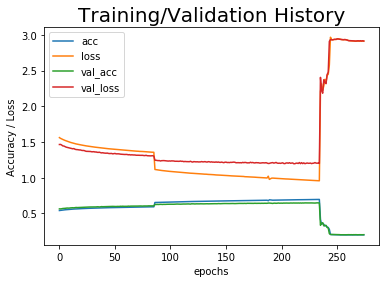

In [66]:
hist = pickle.load(open(ROOT + 'Hunter/Results/loss_acc_final.p','rb'))
for field in hist.keys():
    plt.plot(hist[field], label=field)
plt.xlabel('epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training/Validation History', FontSize = 20)
plt.legend()
plt.show()

# Burnout ?
There are 2 weird discontinuities in this plot. The first one is from switching the dropout of the network from 0.5 to 0.1! Honestly that made it improve a lot, the high dropout was preventing it from learning words properly. The second one I am sort of baffled by. Loss was diminishing gradually and then out of nowhere the network forgot everything! I have no idea why this happened. I found people talk about "catastrophic forgetting", which is when a network forgets how to do a previous task, once it's taught a new one. That would fit here, except, that we were not teaching it anything new. Big mystery. Maybe reading too much Hunter S. Thompson, the network got burned out on a bad trip and forgot everything. Below is what it came to look like:

In [67]:
model = load_model(ROOT + model_dir + 'burnout_model.hdf5')
generate_text(model, output_length = 1000, temp = 0.5)


********************************************************************************
GENERATED OUTPUT
********************************************************************************

 aas.yt  w amts  tdehrh bi  ioey to uate ii h thl mhem rh gou -  ueaedf  f  ehif tegh toer th aoo t toow t ta ah tht aa  ho ow e ta h t t aw to and thlt toi ju hh ie totlaran toh ti ah iovld ao th t e. a oo io tuf-re f-   yie to  uo  afe tf v te ga m  a tomc i t tse tfo to to tad wo  tt s the  au te-r soo whc  oo  ft f  te w t ea, hoe s t   he tim th t    to si th shdf tht  tue t eat to de rnt vek ho te t  ov  foee theh av -a a re  e whes og tame to tislg sh t ta t a yy tr toe a mo  no ahi f a co t tre ai sot  lia ta s ne teaon t ga  toie tus rh  a ane wh th t s aoes ao i so  - aod theo aoa  sht eaht t  td t th oho te i the th tm  shcl oo ce  bo bh t tin th ih,o  a an te  aesy  can   f t le t so.eir sd b bdrn tie toe to t tpt i io nh t.t tet da tt taed lo  do b.caas n eh sgm tn .ag t thbe l  a lo  tn o yhekn

# Conclusions
That is all the work we are going to do for HunterBot. It got to learn english pretty well and sound like Hunter! I wrapped everything up and made it into a page in my website. I am satisfied with it, perhaps in the future I would like to experiment with using words instead of characters, and perhaps on using sequence-to-sequence networks instead of a sequence classification method. And finally, below is the progression of HunterBot across training epochs !

In [ ]:
model_dir = 'Hunter/models512/'
#best_model = download_best_model(model_dir = model_dir, min_max = 'min')

model100 = 'weights-improvement-100-1.3565.hdf5'
model200 = 'weights-improvement-200-1.0093.hdf5'
model300 = 'weights-improvement-300-0.9243.hdf5'
model400 = 'weights-improvement-400-0.8480.hdf5'

In [72]:

print('Epoch 100 Model')
model = load_model(ROOT + model_dir + model100)
new_generate_text(model, output_length = 200, temperature = 0.5)

Epoch 100 Model

********************************************************************************
GENERATED OUTPUT
********************************************************************************

lowing press corps was still a problem with a serious problem. the press corps was still a problem with a series of pressure of the press corps, and the president was a problem with the press conferen

********************************************************************************


In [73]:
print('Epoch 200 Model')
model = load_model(ROOT + model_dir + model200)
new_generate_text(model, output_length = 200, temperature = 0.5)

Epoch 200 Model

********************************************************************************
GENERATED OUTPUT
********************************************************************************

ime mind in the county country.

the first time i started the story of the police, when i finally got the beer and watched him as a man who was still struggling with a big smile. "we're gonna get it o

********************************************************************************


In [74]:
print('Epoch 300 Model')
model = load_model(ROOT + model_dir + model300)
new_generate_text(model, output_length = 200, temperature = 0.5)

Epoch 300 Model

********************************************************************************
GENERATED OUTPUT
********************************************************************************

ld happen if you want to know they've been looking for a month. . ."
"what?"
"yeah, i said. i'm going to see the police chief. you know, i said. im your attorney. he was staying in the back seat, but 

********************************************************************************


In [75]:
print('Epoch 400 Model')
model = load_model(ROOT + model_dir + model400)
new_generate_text(model, output_length = 200, temperature = 0.5)

Epoch 400 Model

********************************************************************************
GENERATED OUTPUT
********************************************************************************

xpense and the same kind of conventional political community.

there was also the first time in the watergate hearings, and they were going to have to play it was on the surface.

* * *

"what will go

********************************************************************************
